In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [4]:
dataset = raw_dataset.copy()
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


### Data Cleaning

In [5]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [6]:
dataset.dropna(inplace=True)

In [7]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [8]:
dataset['Origin']

0         USA
1         USA
2         USA
3         USA
4         USA
        ...  
393       USA
394    Europe
395       USA
396       USA
397       USA
Name: Origin, Length: 392, dtype: object

In [9]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [10]:
train_dataset = dataset.sample(frac=0.8, random_state=42)
test_dataset = dataset.drop(train_dataset.index)

### Data exploration

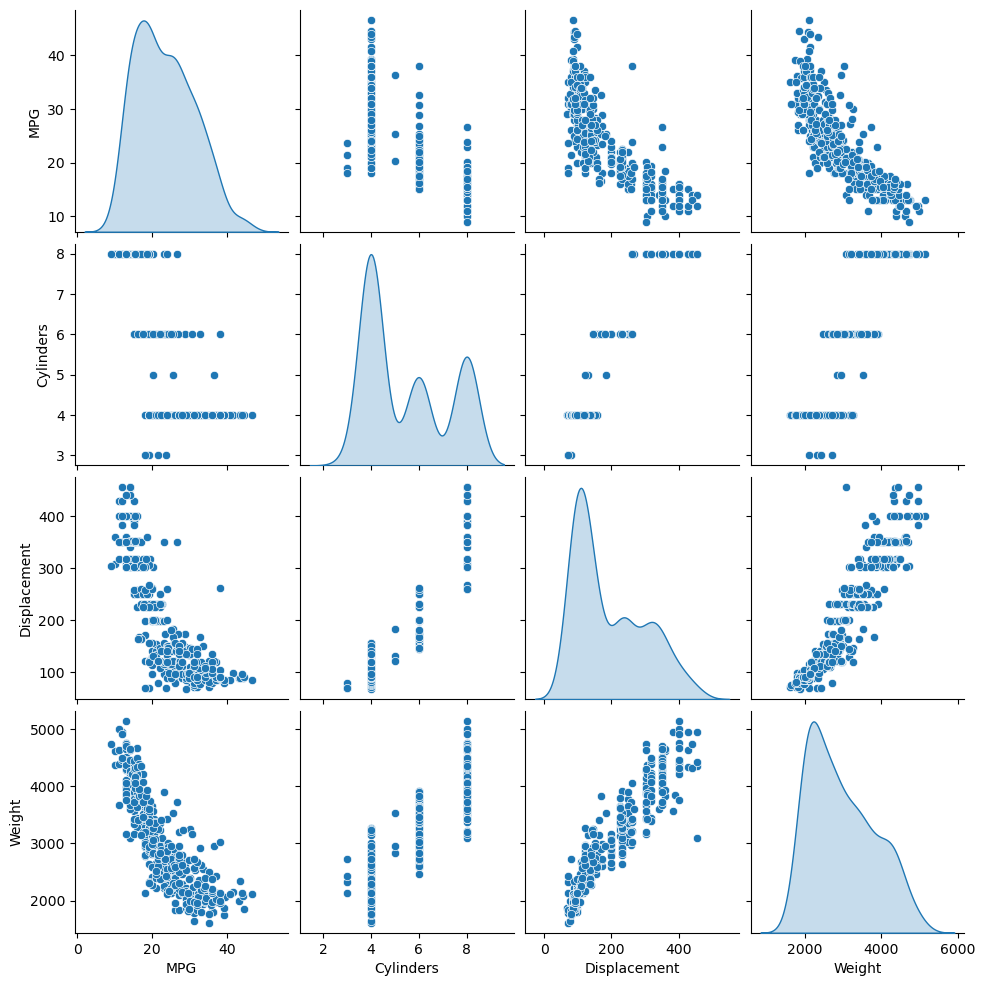

In [11]:
sns.pairplot(dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [12]:
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,392.0,23.445918,7.805007,9.0,17.000,22.75,29.000,46.6
Cylinders,392.0,5.471939,1.705783,3.0,4.000,4.00,8.000,8.0
Displacement,392.0,194.411990,104.644004,68.0,105.000,151.00,275.750,455.0
Horsepower,392.0,104.469388,38.491160,46.0,75.000,93.50,126.000,230.0
Weight,392.0,2977.584184,849.402560,1613.0,2225.250,2803.50,3614.750,5140.0
Acceleration,392.0,15.541327,2.758864,8.0,13.775,15.50,17.025,24.8
Model Year,392.0,75.979592,3.683737,70.0,73.000,76.00,79.000,82.0
Europe,392.0,0.173469,0.379136,0.0,0.000,0.00,0.000,1.0
Japan,392.0,0.201531,0.401656,0.0,0.000,0.00,0.000,1.0
USA,392.0,0.625000,0.484742,0.0,0.000,1.00,1.000,1.0


In [13]:
X_train = train_dataset.copy()
X_test = test_dataset.copy()

y_train = train_dataset.pop('MPG')
y_test = test_dataset.pop('MPG')

X_train = X_train.drop(columns=['MPG'])
X_test = X_test.drop(columns=['MPG'])

In [14]:
X_train

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
79,4,96.0,69.0,2189.0,18.0,72,1,0,0
276,4,121.0,115.0,2795.0,15.7,78,1,0,0
248,4,91.0,60.0,1800.0,16.4,78,0,1,0
56,4,91.0,70.0,1955.0,20.5,71,0,0,1
393,4,140.0,86.0,2790.0,15.6,82,0,0,1
...,...,...,...,...,...,...,...,...,...
218,4,79.0,58.0,1825.0,18.6,77,1,0,0
281,6,200.0,85.0,2990.0,18.2,79,0,0,1
342,4,135.0,84.0,2385.0,12.9,81,0,0,1
238,4,98.0,83.0,2075.0,15.9,77,0,0,1


### Normalization

In [15]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [16]:
normalizer.adapt(np.array(X_train))

2022-11-10 21:20:27.728979: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
print(normalizer.mean.numpy())

[[   5.532  197.855  105.971 3005.746   15.511   75.911    0.172    0.204
     0.624]]


In [18]:
first = np.array(X_train[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   4.   96.   69. 2189.   18.   72.    1.    0.    0.]]

Normalized: [[-0.89 -0.96 -0.93 -0.95  0.89 -1.06  2.19 -0.51 -1.29]]


### Prediction with one variable

In [19]:
horsepower = np.array(X_train['Horsepower'])

horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

In [20]:
model = keras.Sequential()
model.add(horsepower_normalizer)
#model.add(layers.Dense(50, activation='relu'))
#model.add(layers.Dense(50, activation='relu'))
#model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(1))

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_absolute_error')

In [22]:
history = model.fit(X_train['Horsepower'], y_train, epochs=1000, batch_size=1064, verbose=0, validation_split=0.15)

In [23]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
995,3.848901,3.429579,995
996,3.848902,3.429710,996
997,3.848900,3.430037,997
998,3.848896,3.430543,998
999,3.848889,3.431210,999


In [24]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

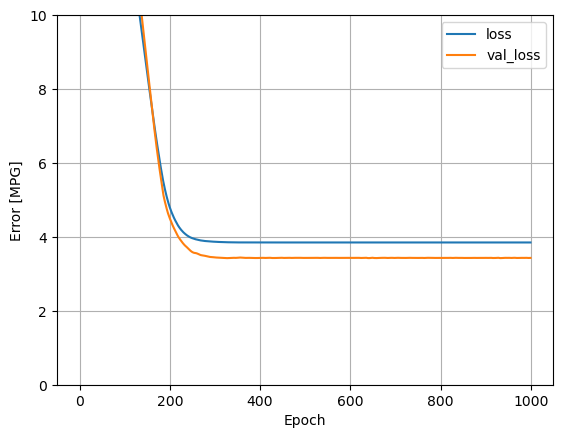

In [25]:
plot_loss(history)

In [26]:
test_results = {}

test_results['horsepower_model'] = model.evaluate(
    x=X_test['Horsepower'],
    y=y_test,
    batch_size=1064,
    verbose="auto"
)

1/1 [==============================] - 0s 20ms/step - loss: 3.9423


In [27]:
x = tf.linspace(0.0, 250, 251)
y = model.predict(x)

8/8 [==============================] - 0s 829us/step


In [28]:
def plot_horsepower(x, y):
  plt.scatter(X_train['Horsepower'], y_train, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

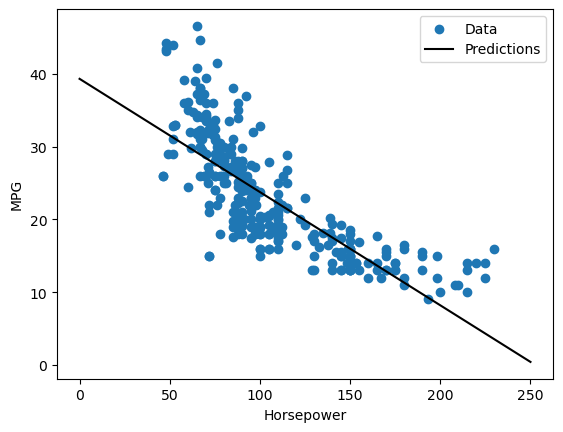

In [29]:
plot_horsepower(x, y)

### Prediction with all variables

In [45]:
model = keras.Sequential()
model.add(normalizer)
#model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

In [46]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_absolute_error')

In [47]:
history = model.fit(X_train, y_train, epochs=200, verbose=0, validation_split=0.3)

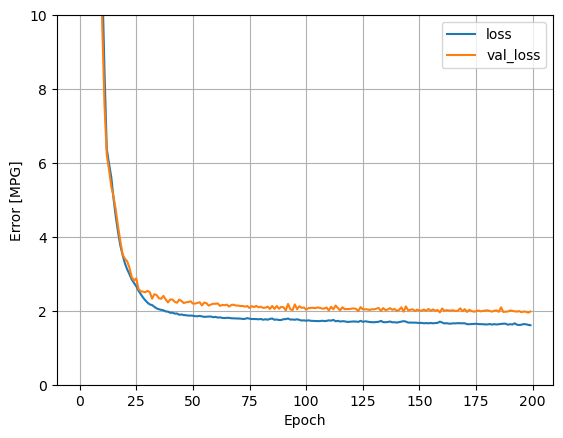

In [48]:
plot_loss(history)

In [49]:
model.evaluate(X_test, y_test, verbose='auto')

3/3 [==============================] - 0s 2ms/step - loss: 1.8767


1.8767054080963135